In [53]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [131]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import RidgeCV, LinearRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier
%matplotlib inline

Загружаем данные

In [53]:
train_set = pd.read_csv(os.path.join('data', 'train.csv'), parse_dates=['timestamp'])

In [54]:
test_set = pd.read_csv(os.path.join('data', 'test.csv'), parse_dates=['timestamp'])

In [55]:
macro = pd.read_csv(os.path.join('data', 'macro.csv'), parse_dates=['timestamp'])

In [56]:
print(train_set.shape)
print(test_set.shape)
print(macro.shape)

(30471, 292)
(7662, 291)
(2484, 100)


Проверяем количество пропущенных значений

In [57]:
train_set.isna().sum()

id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

In [58]:
test_set.isna().sum()

id                       0
timestamp                0
full_sq                  0
life_sq               1176
floor                    0
                      ... 
church_count_5000        0
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
Length: 291, dtype: int64

In [59]:
macro.isna().sum()

timestamp                         0
oil_urals                         0
gdp_quart                        90
gdp_quart_growth                 90
cpi                              31
                               ... 
bandwidth_sports                658
population_reg_sports_share    1023
students_reg_sports_share      1023
apartment_build                 658
apartment_fund_sqm              658
Length: 100, dtype: int64

In [60]:
train_set.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [61]:
test_set.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [62]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


В описании соревнований указано, что у некоторых объектов некорректно указан адрес. Подгружаем данные для исправления

In [63]:
adress_fix = pd.read_excel(os.path.join('data', 'BAD_ADDRESS_FIX.xlsx'))

In [64]:
adress_fix.shape

(699, 280)

In [65]:
adress_fix.head()

,id,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,314,Chertanovo Severnoe,6.206099e+06,111874,0.128123,0.089040,4720,2881.0,5,7976,...,40,11,1,0,6,30,1,4,42,12
1,930,Krjukovo,1.084231e+07,85219,0.062172,0.161532,5767,5278.0,6,5648,...,4,0,0,0,0,2,0,1,8,1
2,1520,Rostokino,3.497819e+06,37502,0.146941,0.210473,2334,1040.0,1,2398,...,42,28,3,0,15,35,1,4,85,5
3,2391,Chertanovo Severnoe,6.206099e+06,111874,0.128123,0.089040,4720,2881.0,5,7976,...,40,11,1,0,6,30,1,4,42,12
4,2447,Chertanovo Severnoe,6.206099e+06,111874,0.128123,0.089040,4720,2881.0,5,7976,...,40,11,1,0,6,30,1,4,42,12


In [66]:
train_set[adress_fix.columns][train_set.id == 314]

,id,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
313,314,Tverskoe,7307410.574,75377,0.065444,0.000078,4237,1874.0,4,6398,...,636,371,141,26,150,249,2,105,203,13


Заменяем значения на корректные

In [67]:
for i in adress_fix.id:
    if i in train_set.id.tolist():
        for j in adress_fix.columns:
            train_set.loc[train_set.id == i, j] = adress_fix[j].loc[adress_fix.id == i].iloc[0]
    else:
        for j in adress_fix.columns:
            test_set.loc[test_set.id == i, j] = adress_fix[j].loc[adress_fix.id == i].iloc[0]

In [68]:
train_set[adress_fix.columns][train_set.id == 314]

,id,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
313,314,Chertanovo Severnoe,6206098.885,111874,0.128123,0.08904,4720,2881.0,5,7976,...,40,11,1,0,6,30,1,4,42,12


In [69]:
print(train_set.shape)
print(test_set.shape)

(30471, 292)
(7662, 291)


Предобратываем данные от пропусков и аномалий

In [70]:
train_set.isna().sum()

id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

In [71]:
train_set[train_set.life_sq.isna()].head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
559,560,2011-12-07,73,NaN,14.0,NaN,NaN,NaN,NaN,NaN,...,34,4,0,17,37,0,8,95,4,10100958
624,625,2011-12-15,110,NaN,26.0,NaN,NaN,NaN,NaN,NaN,...,82,22,3,68,101,1,22,111,14,16118400
783,784,2012-01-12,167,NaN,32.0,NaN,NaN,NaN,NaN,NaN,...,310,128,22,132,196,1,88,164,12,23435712
824,825,2012-01-16,53,NaN,6.0,NaN,NaN,NaN,NaN,NaN,...,18,3,0,11,12,0,1,56,5,8794500
834,835,2012-01-17,81,NaN,16.0,NaN,NaN,NaN,NaN,NaN,...,38,8,2,19,37,2,12,77,10,18668824


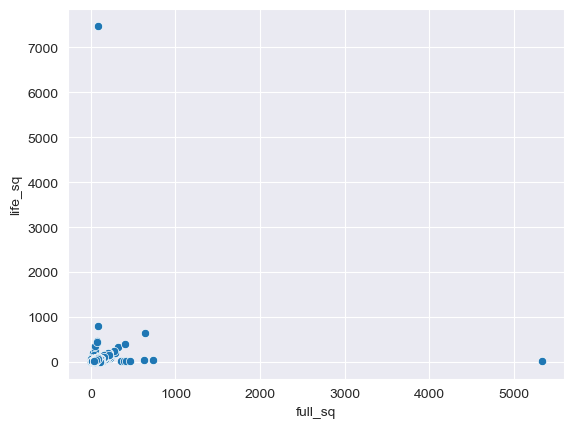

In [72]:
sns.scatterplot(x='full_sq', y='life_sq', data=train_set[['full_sq', 'life_sq']])
plt.show();

In [73]:
train_set[(train_set.full_sq > 300) & (train_set.price_doc < 15000000)]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
128,129,2011-10-15,325,325.0,7.0,NaN,NaN,NaN,NaN,NaN,...,3,1,0,7,14,0,9,44,10,5000000
1478,1481,2012-03-11,353,20.0,5.0,NaN,NaN,NaN,NaN,NaN,...,4,2,0,3,9,0,1,14,2,4750000
1610,1613,2012-03-21,394,17.0,11.0,NaN,NaN,NaN,NaN,NaN,...,6,1,0,8,23,0,3,55,9,1050000
2425,2428,2012-06-07,412,17.0,6.0,NaN,NaN,NaN,NaN,NaN,...,74,36,5,14,34,1,6,92,5,6117000
2780,2783,2012-07-06,729,44.0,12.0,NaN,NaN,NaN,NaN,NaN,...,27,5,1,5,24,1,4,63,6,13250000
3527,3530,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,...,7,2,0,5,16,0,2,43,6,6868818
3596,3599,2012-09-12,388,NaN,9.0,NaN,NaN,NaN,NaN,NaN,...,1,0,0,4,6,0,0,4,1,3899400
5944,5947,2013-02-07,634,38.0,3.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,8,12,1,0,40,5,10200000
7207,7210,2013-04-10,461,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4,2,0,8,25,0,6,56,9,5750000
18341,18344,2014-05-13,634,NaN,3.0,17.0,1.0,NaN,2.0,0.0,...,1,0,0,2,3,0,0,6,1,6213200


Создадим функции по трансформации ДФ

In [74]:
def df_transformer(df):
    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef


    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)

    # Вот так выглядят данные после преобразования
    #sns.scatterplot(x='full_sq', y='life_sq', data=df[['full_sq', 'life_sq']])
    #plt.show();

    # год постройки имеет несуществущие значения. Целесообразно преобразовать
    if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():

        mean_year = round(df.build_year[(df.build_year > 1700) &
                                        (df.build_year < 2022)].mean())

        df.build_year = df.build_year.fillna(mean_year)
        df.loc[~((df.build_year > 1700) &
                 (df.build_year < 2022)), 'build_year'] = mean_year

    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        df[i].fillna(df[i].median(), inplace=True)

    df_with_macro = df.merge(time_macro, on='timestamp', how='left')

    df_with_macro['year'] = df_with_macro.timestamp.dt.year
    df_with_macro['month'] = df_with_macro.timestamp.dt.month
    df_with_macro['day'] = df_with_macro.timestamp.dt.day

    df_with_macro = df_with_macro.drop('timestamp', axis=1)
    df_with_macro = df_with_macro.drop('id', axis=1)

    for i in df_with_macro.columns:
        col_type = df_with_macro[i].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_with_macro[i].fillna(df_with_macro[i].mode(), inplace=True)
            df_with_macro[i].replace({'yes': 1, 'no': 0}, inplace=True)
            #if df_with_macro[i].dtype == 'object':
                #df_with_macro[i] = df_with_macro[i].astype('category')

    return df_with_macro

Создадим функции для использования с Pipeline

In [75]:
replacer_for_pipline = FunctionTransformer(df_transformer)
cat_encoding = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

В обучающем ДФ есть объект без площади. Удалим его

In [76]:
train_set[train_set.full_sq == 0]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
17932,17935,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,1,7,1,0,12,1,4425000
24296,24299,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0,...,1,1,0,2,12,0,1,10,0,8167508


In [77]:
train_set = train_set.drop(17932)

In [78]:
train_set[train_set.full_sq == 0]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
24296,24299,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0,...,1,1,0,2,12,0,1,10,0,8167508


Удалим данные по объектам с аномальной площадью

In [79]:
train_set = train_set\
                       .drop(train_set[(train_set.full_sq > 300)
                                                  & (train_set.price_doc < 15000000)]\
                       .index.tolist())

In [80]:
train_set[(train_set.full_sq > 300) & (train_set.price_doc < 15000000)]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc


Преобразуем Датасет с экономическими показателями

In [81]:
time_macro = macro.set_index('timestamp')

In [82]:
time_macro.head()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,43.4054,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,42.9600,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [83]:
time_macro.isna().sum()

oil_urals                         0
gdp_quart                        90
gdp_quart_growth                 90
cpi                              31
ppi                              31
                               ... 
bandwidth_sports                658
population_reg_sports_share    1023
students_reg_sports_share      1023
apartment_build                 658
apartment_fund_sqm              658
Length: 99, dtype: int64

In [84]:
time_macro.dtypes

oil_urals                      float64
gdp_quart                      float64
gdp_quart_growth               float64
cpi                            float64
ppi                            float64
                                ...   
bandwidth_sports               float64
population_reg_sports_share    float64
students_reg_sports_share      float64
apartment_build                float64
apartment_fund_sqm             float64
Length: 99, dtype: object

In [85]:
time_macro[['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']].head()

,child_on_acc_pre_school,modern_education_share,old_education_build_share
timestamp,,,
2010-01-01,"45,713",NaN,NaN
2010-01-02,"45,713",NaN,NaN
2010-01-03,"45,713",NaN,NaN
2010-01-04,"45,713",NaN,NaN
2010-01-05,"45,713",NaN,NaN


In [86]:
time_macro.child_on_acc_pre_school.unique()

array(['45,713', '#!', '7,311', '3,013', '16,765', nan], dtype=object)

In [87]:
time_macro.modern_education_share.unique()

array([nan, '90,92', '93,08', '95,4918'], dtype=object)

In [88]:
time_macro.old_education_build_share.unique()

array([nan, '23,14', '25,47', '8,2517'], dtype=object)

In [89]:
time_macro['modern_education_share'] = time_macro['modern_education_share'].str.replace(',', ".").astype(float)

In [90]:
time_macro.old_education_build_share = time_macro.old_education_build_share.str.replace(',', ".").astype(float)

In [91]:
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.str.replace(',', ".")

In [92]:
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.replace({'#!': np.nan})

In [93]:
time_macro.child_on_acc_pre_school = time_macro.child_on_acc_pre_school.astype(float)

Заменям пропущенные значения в обе стороны

In [94]:
for i in time_macro:
    if time_macro[i].isna().sum() > 0:
        time_macro[i].fillna(time_macro[i].interpolate(method='time'), inplace=True)

In [95]:
for i in time_macro:
    if time_macro[i].isna().sum() > 0:
        time_macro[i].fillna(time_macro[i].interpolate(method='time', limit_direction ='backward'), inplace=True)

In [96]:
time_macro.isna().sum()

oil_urals                      0
gdp_quart                      0
gdp_quart_growth               0
cpi                            0
ppi                            0
                              ..
bandwidth_sports               0
population_reg_sports_share    0
students_reg_sports_share      0
apartment_build                0
apartment_fund_sqm             0
Length: 99, dtype: int64

In [97]:
time_macro = time_macro.reset_index()

In [98]:
time_macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,9995.8,4.1,315.1,337.2,86.721,18.114,14.1,29.905,...,690.0,6221.0,527.0,0.41,993.0,269768.0,22.37,63.03,22825.0,230310.0
1,2010-01-02,76.1,9995.8,4.1,315.1,337.2,86.721,18.114,14.1,29.905,...,690.0,6221.0,527.0,0.41,993.0,269768.0,22.37,63.03,22825.0,230310.0
2,2010-01-03,76.1,9995.8,4.1,315.1,337.2,86.721,18.114,14.1,29.905,...,690.0,6221.0,527.0,0.41,993.0,269768.0,22.37,63.03,22825.0,230310.0
3,2010-01-04,76.1,9995.8,4.1,315.1,337.2,86.721,18.114,14.1,29.905,...,690.0,6221.0,527.0,0.41,993.0,269768.0,22.37,63.03,22825.0,230310.0
4,2010-01-05,76.1,9995.8,4.1,315.1,337.2,86.721,18.114,14.1,29.836,...,690.0,6221.0,527.0,0.41,993.0,269768.0,22.37,63.03,22825.0,230310.0


Пробуем обучить несколько моделей c базовыми параметрами

In [45]:
y_train = train_set.price_doc.copy()
log_y = np.log(y_train)
train_set.drop('price_doc', axis=1, inplace=True)

In [51]:
model = Pipeline(
                 [('fillna', replacer_for_pipline),
                  ('cat_encoding', cat_encoding),
                  ('model', CatBoostRegressor(task_type="GPU"))]
                )

In [ ]:
param_grid = {'model': [LGBMRegressor(device='gpu', random_state=42),

                        CatBoostRegressor(task_type="GPU", random_state=42),

                        XGBRegressor(eval_metric='rmsle',
                                       tree_method='gpu_hist',
                                       predictor='gpu_predictor',
                                       random_state=42),

                        RidgeCV()]
}

best_model= GridSearchCV(model,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_log_error', error_score='raise')

best_model.fit(train_set, log_y)

In [53]:
print(f'RMSLE для лучшей модели: {np.sqrt(best_model.best_score_.mean() * -1)}')

RMSLE для лучшей модели: 0.03433946051949982


In [54]:
best_model.best_estimator_

Pipeline(steps=[('fillna',
                 FunctionTransformer(func=<function df_transformer at 0x00000234AFBBFA60>)),
                ('cat_encoding',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x00000234AC414520>)])

CatBoostRegressor без настройки показал лучший результат. Пробуем его настроить.
В документации рекомендовано не преобразовывать категориальные признаки заранее. Создадим новые функции обработки

In [99]:
def df_transformer(df):
    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef

    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)

    # Вот так выглядят данные после преобразования
    #sns.scatterplot(x='full_sq', y='life_sq', data=df[['full_sq', 'life_sq']])
    #plt.show();

    # год постройки имеет несуществущие значения. Целесообразно преобразовать
    if 'build_year' in df.columns:
        if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():
            mean_year = round(df.build_year[(df.build_year > 1700) &
                                            (df.build_year < 2022)].mean())

            df.build_year = df.build_year.fillna(mean_year)
            df.loc[~((df.build_year > 1700) &
                     (df.build_year < 2022)), 'build_year'] = mean_year

    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        if i in df.columns:
            df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        if i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)

    df_with_macro = df.merge(time_macro, on='timestamp', how='left')

    df_with_macro['year'] = df_with_macro.timestamp.dt.year
    df_with_macro['month'] = df_with_macro.timestamp.dt.month
    df_with_macro['day'] = df_with_macro.timestamp.dt.day

    df_with_macro = df_with_macro.drop('timestamp', axis=1)
    df_with_macro = df_with_macro.drop('id', axis=1)

    for i in df_with_macro.columns:
        col_type = df_with_macro[i].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_with_macro[i] = df_with_macro[i].astype('category')

    return df_with_macro

In [100]:
def yes_no_replacer(df):
    np.place(df, df == 'yes', 1)
    np.place(df, df == 'no', 0)
    return df

In [101]:
replacer_for_pipline = FunctionTransformer(df_transformer)
yes_no_replacer_for_pipline = FunctionTransformer(yes_no_replacer)
imp = SimpleImputer(strategy='most_frequent')
cboost_model = CatBoostRegressor(task_type="GPU",
                                                  cat_features= [9, 10, 27,
                                                                31, 32, 33,
                                                                34, 35, 36,
                                                                37, 38, 104,
                                                                112, 116, 150])

In [53]:
model = Pipeline(
                 [('fillna', replacer_for_pipline),
                  ('imputer', imp),
                  ('yes_no_to_0_1', yes_no_replacer_for_pipline),
                  ('model', cboost_model)
                 ]
                )

In [ ]:
param_grid = {'yes_no_to_0_1': [yes_no_replacer_for_pipline, None],
              'model__n_estimators': [100, 200, 300, 400, 500, 1000],
              'model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
              'model__max_depth': [4, 5, 6, 7, 8, 10, 11, 12 ,13],
              'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
              'model__leaf_estimation_iterations': [1, 2, 3],
              'model__leaf_estimation_backtracking': ['No', 'AnyImprovement', 'Armijo']
}

best_model= RandomizedSearchCV(model,
                                param_distributions=param_grid, n_iter=150,
                                scoring='neg_mean_squared_log_error', error_score='raise', cv=5, random_state=42)

best_model.fit(train_set, log_y)

In [56]:
print(f'RMSLE для лучшей модели: {np.sqrt(best_model.best_score_.mean() * -1)}')

RMSLE для лучшей модели: 0.0289990759027644


In [55]:
best_model.best_params_

{'yes_no_to_0_1': FunctionTransformer(func=<function yes_no_replacer at 0x00000203C2BF55E0>),
 'model__n_estimators': 1000,
 'model__max_depth': 10,
 'model__learning_rate': 0.01,
 'model__leaf_estimation_iterations': 2,
 'model__leaf_estimation_backtracking': 'Armijo',
 'model__grow_policy': 'SymmetricTree'}

In [57]:
pred_log = best_model.predict(test_set)

In [58]:
results = pd.concat([test_set.id, pd.Series(np.exp(pred_log))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results4.csv', index=False)

In [105]:
cat_model = CatBoostRegressor(n_estimators=1000,
                              max_depth=10,
                              learning_rate=0.01,
                              task_type="GPU",
                              cat_features= [9, 10, 27,
                                             31, 32, 33,
                                             34, 35, 36,
                                             37, 38, 104,
                                             112, 116, 150],
                              leaf_estimation_iterations=2,
                              leaf_estimation_backtracking='Armijo',
                              grow_policy='SymmetricTree'
                             )

In [106]:
model2 = Pipeline(
                 [
                  ('fillna', replacer_for_pipline),
                  ('imputer', imp),
                  ('yes_no_to_0_1', yes_no_replacer_for_pipline),
                  ('model', cat_model)
                 ]
                )

In [ ]:
model2.fit(train_set, log_y)

In [108]:
pred2 = model2.predict(test_set)

In [109]:
results = pd.concat([test_set.id, pd.Series(np.exp(pred2))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_with_yes_no.csv', index=False)

In [68]:
np.where(cat_model.feature_importances_ == 0)

(array([ 17,  31,  32,  33,  34,  36,  37, 193, 216, 239, 285, 296, 303,
        317, 318, 325, 336, 338, 341, 342, 343, 346, 347, 348, 352, 353,
        356, 368, 369, 370, 373, 377, 378, 387], dtype=int64),)

In [ ]:
cat_model = CatBoostRegressor(n_estimators=1000,
                              max_depth=10,
                              learning_rate=0.01,
                              task_type="GPU",
                              cat_features=[9, 10, 27,
                                            31, 32, 33,
                                            34, 35, 36,
                                            37, 38, 104,
                                            112, 116, 150],
                              leaf_estimation_iterations=2,
                              leaf_estimation_backtracking='Armijo',
                              grow_policy='SymmetricTree'
                              )
model2 = Pipeline(
    [
        ('fillna', replacer_for_pipline),
        ('imputer', imp),
        ('model', cat_model)
    ]
)
model2.fit(train_set, log_y)
pred2 = model2.predict(test_set)
results = pd.concat([test_set.id, pd.Series(np.exp(pred2))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results5.csv', index=False)

Обучение с удаленными колонками

In [73]:
col = ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
     'num_room', 'kitch_sq', 'product_type', 'sub_area', 'area_m', 'raion_popul',
     'green_zone_part', 'indust_part', 'preschool_quota', 'school_education_centers_top_20_raion',
     'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion',
     'additional_education_raion', 'culture_objects_top_25', 'culture_objects_top_25_raion',
     'shopping_centers_raion', 'office_raion', 'thermal_power_plant_raion', 'incineration_raion',
     'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion',
     'nuclear_reactor_raion', 'detention_facility_raion', 'full_all', 'build_count_block',
     'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith',
     'build_count_panel', 'build_count_foam', 'build_count_mix', 'raion_build_count_with_builddate_info',
     'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',
     'build_count_after_1995', 'ID_metro', 'metro_km_avto', 'kindergarten_km', 'school_km',
     'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km',
     'incineration_km', 'ID_railroad_station_walk', 'railroad_station_avto_km',
     'ID_railroad_station_avto', 'public_transport_station_min_walk', 'water_km',
     'water_1line', 'mkad_km', 'big_road1_km', 'ID_big_road1', 'big_road1_1line', 'big_road2_km',
     'ID_big_road2', 'railroad_km', 'railroad_1line', 'ID_railroad_terminal', 'bus_terminal_avto_km',
     'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km',
     'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km',
     'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km',
     'detention_facility_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
     'office_km', 'additional_education_km', 'big_church_km', 'church_synagogue_km', 'mosque_km',
     'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'ecology', 'green_part_500',
     'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500',
     'cafe_count_500_na_price', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
     'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500',
     'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500',
     'green_part_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000_price_high',
     'big_church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000',
     'market_count_1000', 'trc_count_1500', 'trc_sqm_1500', 'mosque_count_1500', 'sport_count_1500',
     'market_count_1500', 'prom_part_2000', 'trc_sqm_2000', 'cafe_avg_price_2000', 'mosque_count_2000',
     'market_count_2000', 'green_part_3000', 'prom_part_3000', 'trc_sqm_3000', 'mosque_count_3000',
     'market_count_3000', 'green_part_5000', 'prom_part_5000', 'trc_sqm_5000', 'cafe_sum_5000_min_price_avg',
     'mosque_count_5000', 'market_count_5000', 'price_doc']

In [ ]:
train_set2 = pd.read_csv(os.path.join('data', 'train.csv'), parse_dates=['timestamp'])

adress_fix = pd.read_excel(os.path.join('data', 'BAD_ADDRESS_FIX.xlsx'))

for i in adress_fix.id:
    if i in train_set2.id.tolist():
        for j in adress_fix.columns:
            train_set2.loc[train_set2.id == i, j] = adress_fix[j].loc[adress_fix.id == i].iloc[0]

modified_train = train_set2[col].copy()

modified_train = modified_train.drop(17932)

modified_train = modified_train \
    .drop(modified_train[(modified_train.full_sq > 300)
                         & (modified_train.price_doc < 15000000)] \
          .index.tolist())

In [93]:
cat_features_new = [modified_train.columns.get_loc(col) for col in
                    modified_train.select_dtypes(include=['object', 'bool']).columns]
cat_features_new = [i - 2 for i in cat_features_new]
cat_features_new

[7, 8, 19, 23, 24, 25, 26, 27, 28, 29, 30, 61, 65, 69, 100]

In [94]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features= cat_features_new,
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                             )

In [95]:
model2 = Pipeline(
                 [
                  ('fillna', replacer_for_pipline),
                  ('imputer', imp),
                  ('model', cat_model2)
                 ]
                )

In [81]:
y_train2 = modified_train.price_doc.copy()
log_y2 = np.log(y_train2)
modified_train.drop('price_doc', axis=1, inplace=True)

In [ ]:
cv = cross_val_score(model2, modified_train, log_y2, scoring='neg_mean_squared_log_error', error_score='raise', cv=5)

In [98]:
print(f'RMSLE для лучшей модели: {np.sqrt(cv.mean() * -1)}')

RMSLE для лучшей модели: 0.029137494965824615


In [ ]:
model2.fit(modified_train, log_y2)

In [105]:
pred_modified = model2.predict(test_set[col[:-1]].copy())

In [106]:
results = pd.concat([test_set.id, pd.Series(np.exp(pred_modified))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_short_model_1.csv', index=False)

Модель с уменьшенным до 147 числом признаков показала сопоставимое качество с моделью с полным набором параметров

**Т.к. анализировть большое число признаков затруднительно, то пробуем другой подход.
На этот раз будем удалять признаки, которые модель считает несущественными**

In [108]:
# С предыдущего обучения остался стартовый набор несущественных признаков
np.where(cat_model.feature_importances_ == 0)

(array([ 17,  31,  32,  33,  34,  36,  37, 193, 216, 239, 285, 296, 303,
        317, 318, 325, 336, 338, 341, 342, 343, 346, 347, 348, 352, 353,
        356, 368, 369, 370, 373, 377, 378, 387], dtype=int64),)

In [113]:
modified_train2 = train_set2.copy()

modified_train2 = modified_train2.drop(17932)

modified_train2 = modified_train2 \
    .drop(modified_train2[(modified_train2.full_sq > 300)
                         & (modified_train2.price_doc < 15000000)] \
          .index.tolist())

In [114]:
modified_train2.shape

(30457, 292)

In [124]:
columns_for_drop = []

for i in [x + 2 for x in [17, 31, 32, 33, 34, 36, 37, 193, 216, 239, 285]]:
    columns_for_drop.append(modified_train2.columns.tolist()[i])
    print(modified_train2.columns.tolist()[i])

preschool_education_centers_raion
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
big_market_raion
nuclear_reactor_raion
mosque_count_1000
mosque_count_1500
mosque_count_2000
mosque_count_5000


In [125]:
for i in [x - 290 for x in [296, 303,317, 318, 325,
                            336, 338, 341, 342, 343,
                            346, 347, 348, 352, 353,
                            356, 368, 369, 370,
                            373, 377, 378, 387]]:
    columns_for_drop.append(macro.columns.tolist()[i])
    print(macro.columns.tolist()[i])

gdp_deflator
gdp_annual
grp
grp_growth
retail_trade_turnover_per_cap
fin_res_per_cap
divorce_rate
pop_natural_increase
pop_migration
pop_total_inc
housing_fund_sqm
lodging_sqm_per_cap
water_pipes_share
hot_water_share
electric_stove_share
average_life_exp
child_on_acc_pre_school
load_of_teachers_school_per_teacher
students_state_oneshift
provision_doctors
hospital_beds_available_per_cap
hospital_bed_occupancy_per_year
students_reg_sports_share


In [163]:
def df_transformer_with_drop(df):
    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef

    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)

    # Вот так выглядят данные после преобразования
    #sns.scatterplot(x='full_sq', y='life_sq', data=df[['full_sq', 'life_sq']])
    #plt.show();

    # год постройки имеет несуществущие значения. Целесообразно преобразовать
    if 'build_year' in df.columns:
        if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():
            mean_year = round(df.build_year[(df.build_year > 1700) &
                                            (df.build_year < 2022)].mean())

            df.build_year = df.build_year.fillna(mean_year)
            df.loc[~((df.build_year > 1700) &
                     (df.build_year < 2022)), 'build_year'] = mean_year

    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        if i in df.columns:
            df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        if i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)

    df_with_macro = df.merge(time_macro, on='timestamp', how='left')

    df_with_macro['year'] = df_with_macro.timestamp.dt.year
    df_with_macro['month'] = df_with_macro.timestamp.dt.month
    df_with_macro['day'] = df_with_macro.timestamp.dt.day

    df_with_macro = df_with_macro.drop('timestamp', axis=1)
    df_with_macro = df_with_macro.drop('id', axis=1)

    for i in df_with_macro.columns:
        col_type = df_with_macro[i].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_with_macro[i] = df_with_macro[i].astype('category')

    df_with_macro.drop(columns_for_drop, axis=1, inplace=True)

    cat_features_new = [df_with_macro.columns.get_loc(col) for col in
                    df_with_macro.select_dtypes(include=['category']).columns]
    cat_features_new = [i for i in cat_features_new]

    print(cat_features_new)

    return df_with_macro

In [150]:
replace_drop_pipe = FunctionTransformer(df_transformer_with_drop)

In [153]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 26, 30, 31, 97, 105, 109, 143],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('fillna', replace_drop_pipe),
        ('imputer', imp),
        ('model', cat_model2)
    ]
)

In [ ]:
model2.fit(modified_train2.drop('price_doc', axis=1), log_y2)

In [158]:
np.where(cat_model2.feature_importances_ == 0)

(array([ 25,  31, 289, 290, 291, 303, 305, 311, 317, 321, 322, 326, 327,
        328, 337, 339, 340, 345, 348, 353, 355], dtype=int64),)

Получили список еще одних "неважных" признаков.

In [173]:
def droper(df_with_macro, columns_for_drop):

    need_drop = []

    for i in columns_for_drop:
        need_drop.append(df_with_macro.columns.tolist()[i])


    df_with_macro.drop(need_drop, axis=1, inplace=True)

    cat_features_new = [df_with_macro.columns.get_loc(col) for col in
                    df_with_macro.select_dtypes(include=['category']).columns]
    cat_features_new = [i for i in cat_features_new]

    print(cat_features_new)

    return df_with_macro

In [161]:
new_df = modified_train2.drop('price_doc', axis=1)

In [164]:
new_df = df_transformer_with_drop(new_df)

[9, 10, 26, 30, 31, 97, 105, 109, 143]


In [165]:
col_for_drop = [25, 31, 289, 290,
                291, 303, 305, 311,
                317, 321, 322, 326,
                327, 328, 337, 339,
                340, 345, 348, 353,
                355]

In [174]:
new_df = droper(new_df, col_for_drop)

[9, 10, 25, 29, 95, 103, 107, 141]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 25, 29, 95, 103, 107, 141],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [176]:
np.where(cat_model2.feature_importances_ == 0)

(array([ 23,  95, 103, 109, 282, 302, 309, 310, 313, 314, 325], dtype=int64),)

In [177]:
col_for_drop = [23,  95, 103, 109, 282, 302, 309, 310, 313, 314, 325]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 28, 104, 137]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 28, 104, 137],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [179]:
np.where(cat_model2.feature_importances_ == 0)

(array([ 58, 246, 287, 296, 299, 318], dtype=int64),)

In [180]:
col_for_drop = [58, 246, 287, 296, 299, 318]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 28, 103, 136]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 28, 103, 136],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [182]:
np.where(cat_model2.feature_importances_ == 0)

(array([ 28,  63, 290, 293, 311], dtype=int64),)

In [183]:
col_for_drop = [28,  63, 290, 293, 311]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 101, 134]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 101, 134],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [185]:
np.where(cat_model2.feature_importances_ == 0)

(array([296], dtype=int64),)

In [186]:
col_for_drop = [296]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 101, 134]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 101, 134],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [188]:
np.where(cat_model2.feature_importances_ == 0)

(array([293, 296, 297], dtype=int64),)

In [189]:
col_for_drop = [293, 296, 297]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 101, 134]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 101, 134],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [191]:
np.where(cat_model2.feature_importances_ == 0)

(array([294, 302], dtype=int64),)

In [192]:
new_df.shape

(30457, 310)

In [193]:
col_for_drop = [294, 302]
new_df = droper(new_df, col_for_drop)

[9, 10, 24, 101, 134]


In [ ]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               cat_features=[9, 10, 24, 101, 134],
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('imputer', imp),
        ('model', cat_model2)
    ]
)
model2.fit(new_df, log_y2)

In [195]:
np.where(cat_model2.feature_importances_ == 0)

(array([], dtype=int64),)

In [197]:
new_df.shape

(30457, 308)

Итого, осталось 308 признаков

In [199]:
new_df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,rent_price_2room_eco,load_of_teachers_preschool_per_teacher,provision_nurse,turnover_catering_per_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,apartment_build,year,day
0,43.0,27.0,4.0,12.559204,1.827032,1985.0,2.0,6.0,2.0,Investment,...,36.77,793.319561,99.6,6943.0,1240.0,269768.0,22.37,23587.0,2011,20
1,34.0,19.0,3.0,12.559204,1.827032,1985.0,2.0,6.0,2.0,Investment,...,36.77,793.319561,99.6,6943.0,1240.0,269768.0,22.37,23587.0,2011,23
2,43.0,29.0,2.0,12.559204,1.827032,1985.0,2.0,6.0,2.0,Investment,...,36.77,793.319561,99.6,6943.0,1240.0,269768.0,22.37,23587.0,2011,27
3,89.0,50.0,9.0,12.559204,1.827032,1985.0,2.0,6.0,2.0,Investment,...,37.73,793.319561,99.6,6943.0,1240.0,269768.0,22.37,23587.0,2011,1
4,77.0,77.0,4.0,12.559204,1.827032,1985.0,2.0,6.0,2.0,Investment,...,37.73,793.319561,99.6,6943.0,1240.0,269768.0,22.37,23587.0,2011,5


In [201]:
important_columns = new_df.columns.to_list()

In [226]:
importance = pd.DataFrame(cat_model2.feature_importances_)

In [227]:
importance['feature'] = important_columns

In [228]:
importance.columns = ['score', 'feature']

In [234]:
importance = importance.sort_values('score', ascending=False).head(20)

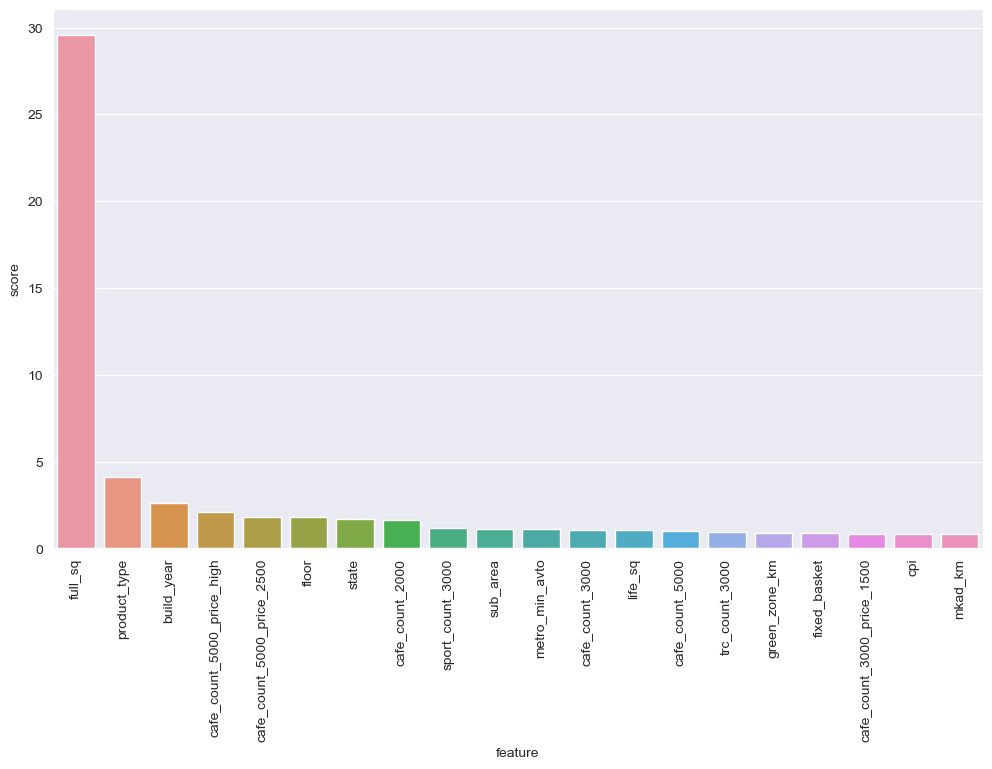

In [247]:
plt.figure(figsize=(12, 7))
sns.barplot(x=importance.feature,y=importance.score)
plt.xticks(rotation=90);

In [248]:
test_set_droped = test_set.copy()

In [249]:

life_sq_coef = np.mean(test_set_droped[(test_set_droped.life_sq != 0) &
                          (test_set_droped.full_sq != 0) &
                          (test_set_droped.life_sq < test_set_droped.full_sq)].life_sq /
                       test_set_droped[(test_set_droped.life_sq != 0) &
                          (test_set_droped.full_sq != 0) &
                          (test_set_droped.life_sq < test_set_droped.full_sq)].full_sq)

life_sq_to_change = test_set_droped[(test_set_droped.life_sq > test_set_droped.full_sq) &
                       (test_set_droped.full_sq > 20)].index.tolist()

for i in life_sq_to_change:
    test_set_droped.iloc[i, 3] = test_set_droped.iloc[i].full_sq * life_sq_coef

# Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
full_sq_to_change = test_set_droped[test_set_droped.life_sq > test_set_droped.full_sq].index.tolist()

for i in full_sq_to_change:
    test_set_droped.iloc[i, 2] = test_set_droped.iloc[i].life_sq / life_sq_coef

indexes = test_set_droped.life_sq[test_set_droped.life_sq.isna()].index
to_fill = test_set_droped.life_sq[test_set_droped.life_sq.isna()].copy()
to_fill = test_set_droped.full_sq[indexes] * life_sq_coef
test_set_droped.life_sq.fillna(to_fill, inplace=True)

if 'build_year' in test_set_droped.columns:
    if test_set_droped.build_year[(test_set_droped.build_year > 1700) & (test_set_droped.build_year < 2022)].any():
        mean_year = round(test_set_droped.build_year[(test_set_droped.build_year > 1700) &
                                        (test_set_droped.build_year < 2022)].mean())

        test_set_droped.build_year = test_set_droped.build_year.fillna(mean_year)
        test_set_droped.loc[~((test_set_droped.build_year > 1700) &
                 (test_set_droped.build_year < 2022)), 'build_year'] = mean_year

mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
               'raion_build_count_with_material_info',
               'build_count_block', 'build_count_wood',
               'preschool_quota', 'school_quota',
               'raion_build_count_with_material_info',
               'build_count_block', 'build_count_wood',
               'build_count_frame', 'build_count_brick',
               'build_count_monolith', 'build_count_panel',
               'build_count_foam', 'build_count_slag',
               'build_count_mix', 'raion_build_count_with_builddate_info',
               'build_count_before_1920', 'build_count_1921-1945',
               'build_count_1946-1970', 'build_count_1971-1995',
               'build_count_after_1995', 'metro_min_walk',
               'metro_km_walk', 'ID_railroad_station_walk',
               'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
               'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
               'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
               'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
               'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                 'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                 'railroad_station_walk_km', 'railroad_station_walk_min',
                 'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                 'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                 ]

for i in mean_change:
    if i in test_set_droped.columns:
        test_set_droped[i].fillna(test_set_droped[i].mean(), inplace=True)
for i in median_change:
    if i in test_set_droped.columns:
        test_set_droped[i].fillna(test_set_droped[i].median(), inplace=True)

df_with_macro = test_set_droped.merge(time_macro, on='timestamp', how='left')

df_with_macro['year'] = df_with_macro.timestamp.dt.year
df_with_macro['month'] = df_with_macro.timestamp.dt.month
df_with_macro['day'] = df_with_macro.timestamp.dt.day

df_with_macro = df_with_macro.drop('timestamp', axis=1)
df_with_macro = df_with_macro.drop('id', axis=1)

for i in df_with_macro.columns:
    col_type = df_with_macro[i].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_with_macro[i] = df_with_macro[i].astype('category')

In [250]:
test_set_droped = df_with_macro[important_columns]

In [251]:
test_set_droped.shape

(7662, 308)

In [252]:
predict_droped_catb = model2.predict(test_set_droped)

In [253]:
results = pd.concat([test_set.id, pd.Series(np.exp(predict_droped_catb))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_drop_col_by_CB.csv', index=False)

In [ ]:
cv = cross_val_score(model2, new_df, log_y2, scoring='neg_mean_squared_log_error', error_score='raise', cv=3)

In [255]:
print(f'RMSLE для лучшей модели: {np.sqrt(cv.mean() * -1)}')

RMSLE для лучшей модели: 0.029181886221927786


И вновь, качество сопоставимо с моделью с полными параметрами. Но по итогам ручного отбора удалось сократить большее количество признаков

**Все же, количество параметров остается большим. Теперь попробуем метод рекурсивного отбора RFE.
Попробуем сократить выбор до 50 признаков**

In [ ]:
log_y = np.log(y_train)
train_for_RFE = train_set.copy()

In [54]:
lr = LinearRegression()

In [301]:
rfe = RFE(lr, n_features_to_select=50)


model_feature = Pipeline(
    [
        ('fillna', replacer_for_pipline),
        ('imputer', imp),
        ('OE', cat_encoding),
        ('model', rfe)
    ]
)

model_feature.fit(train_for_RFE, log_y)

Pipeline(steps=[('fillna',
                 FunctionTransformer(func=<function df_transformer at 0x00000203C2B4BB80>)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('OE',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model',
                 RFE(estimator=LinearRegression(), n_features_to_select=50))])

In [304]:
top_50_features = rfe.get_feature_names_out()

In [309]:
replacer_for_pipline.fit(train_for_RFE)

FunctionTransformer(func=<function df_transformer at 0x00000203C2B4BB80>)

In [313]:
name_columns = replacer_for_pipline.fit_transform(train_for_RFE)\
                                    .iloc[:, [int(i.replace('x', '')) for i in top_50_features.tolist()]]\
                                    .columns.tolist()

In [314]:
name_columns

['num_room',
 'state',
 'product_type',
 'raion_popul',
 'preschool_education_centers_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'work_all',
 'work_male',
 'work_female',
 'raion_build_count_with_material_info',
 'build_count_foam',
 'raion_build_count_with_builddate_info',
 'public_transport_station_km',
 'public_transport_station_min_walk',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'big_church_count_500',
 'church_count_500',
 'mosque_count_500',
 'market_count_500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'leisure_count_1000',
 'mosque_count_1500',
 'cafe_count_2000_price_high',
 'cafe_count_5000_price_high',
 'mosque_count_5000',
 'cpi',
 'gdp_deflator',
 'gdp_annual',
 'gdp_annual_growth',
 'salary',
 'salary_growth',
 'unemployment',
 'invest_fixed_capital_per_cap',
 'invest_fixed_assets',
 'housing_fund_sqm',
 'average_life_exp',
 'provision

In [64]:
def df_transformer_top_50(df):
    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef

    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)


    # год постройки имеет несуществущие значения. Целесообразно преобразовать
    if 'build_year' in df.columns:
        if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():
            mean_year = round(df.build_year[(df.build_year > 1700) &
                                            (df.build_year < 2022)].mean())

            df.build_year = df.build_year.fillna(mean_year)
            df.loc[~((df.build_year > 1700) &
                     (df.build_year < 2022)), 'build_year'] = mean_year

    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        if i in df.columns:
            df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        if i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)

    df_with_macro = df.merge(time_macro, on='timestamp', how='left')

    df_with_macro['year'] = df_with_macro.timestamp.dt.year
    df_with_macro['month'] = df_with_macro.timestamp.dt.month
    df_with_macro['day'] = df_with_macro.timestamp.dt.day

    df_with_macro = df_with_macro.drop('timestamp', axis=1)
    df_with_macro = df_with_macro.drop('id', axis=1)

    for i in df_with_macro.columns:
        col_type = df_with_macro[i].dtype
        if col_type == 'object' or col_type.name == 'category':
            df_with_macro[i] = df_with_macro[i].astype('category')

    df_with_macro = df_with_macro[name_columns].copy()

    cat_features_new = [df_with_macro.columns.get_loc(col) for col in
                    df_with_macro.select_dtypes(include=['category']).columns]
    cat_features_new = [i for i in cat_features_new]

    print(cat_features_new)

    return df_with_macro

In [65]:
make_top_50 = FunctionTransformer(df_transformer_top_50)

In [323]:
cat_model_top_50 = CatBoostRegressor(n_estimators=1000,
                                       max_depth=10,
                                       learning_rate=0.01,
                                       task_type="GPU",
                                       cat_features=[2, 5, 7, 8, 9, 18, 19, 20],
                                       leaf_estimation_iterations=2,
                                       leaf_estimation_backtracking='Armijo',
                                       grow_policy='SymmetricTree'
                                       )
model2 = Pipeline(
    [
        ('droper', make_top_50),
        ('imputer', imp),
        ('model', cat_model_top_50)
    ]
)


In [ ]:
cv = cross_val_score(model2, train_for_RFE, log_y, scoring='neg_mean_squared_log_error', error_score='raise', cv=3)

In [325]:
print(f'RMSLE для топ 50 признаков: {np.sqrt(cv.mean() * -1)}')

RMSLE для топ 50 признаков: 0.03155484239537021


In [ ]:
model2.fit(train_for_RFE, log_y)

In [328]:
predict_top_50 = model2.predict(test_set)

[2, 5, 7, 8, 9, 18, 19, 20]
[2, 5, 7, 8, 9, 18, 19, 20]


In [329]:
results = pd.concat([test_set.id, pd.Series(np.exp(predict_top_50))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_top_50_features.csv', index=False)

Отбор только 50 признаков значительно снижает качество модели. Попробуем оставить 100

In [53]:
train_for_RFE_2 = train_set.copy()

In [55]:
lr = LinearRegression()

In [61]:
rfe = RFE(lr, n_features_to_select=100)


model_feature = Pipeline(
    [
        ('fillna', replacer_for_pipline),
        ('imputer', imp),
        ('OE', cat_encoding),
        ('model', rfe)
    ]
)

model_feature.fit(train_for_RFE_2, log_y)

Pipeline(steps=[('fillna',
                 FunctionTransformer(func=<function df_transformer at 0x0000015DD728CB80>)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('OE',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model',
                 RFE(estimator=LinearRegression(), n_features_to_select=100))])

In [62]:
top_100_features = rfe.get_feature_names_out()
name_columns = replacer_for_pipline.fit_transform(train_for_RFE_2) \
                   .iloc[:, [int(i.replace('x', '')) for i in top_100_features.tolist()]] \
    .columns.tolist()
name_columns

['full_sq',
 'num_room',
 'state',
 'product_type',
 'raion_popul',
 'children_preschool',
 'preschool_education_centers_raion',
 'university_top_20_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'big_market_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekder_male',
 'ekder_female',
 '0_6_all',
 '0_6_male',
 '0_6_female',
 '0_17_all',
 '0_17_female',
 'raion_build_count_with_material_info',
 'build_count_foam',
 'build_count_slag',
 'raion_build_count_with_builddate_info',
 'public_transport_station_km',
 'public_transport_station_min_walk',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'cafe_count_500_price_4000',
 'cafe_count_500_price_high',
 'big_church_count_500',
 'church_count_500',
 'mosque_count_500',
 'market_count_500',
 'cafe_count

In [ ]:
cat_model_top_100 = CatBoostRegressor(n_estimators=1000,
                                     max_depth=10,
                                     learning_rate=0.01,
                                     task_type="GPU",
                                     cat_features=[3, 8, 10, 11, 12, 13, 14, 15, 38, 39, 40],
                                     leaf_estimation_iterations=2,
                                     leaf_estimation_backtracking='Armijo',
                                     grow_policy='SymmetricTree'
                                     )
model2 = Pipeline(
    [
        ('droper', make_top_50),
        ('imputer', imp),
        ('model', cat_model_top_100)
    ]
)

cv = cross_val_score(model2, train_for_RFE_2, log_y, scoring='neg_mean_squared_log_error', error_score='raise', cv=3)

In [69]:
print(f'RMSLE для топ 100 признаков: {np.sqrt(cv.mean() * -1)}')

RMSLE для топ 100 признаков: 0.029387743425195113


In [ ]:
model2.fit(train_for_RFE_2, log_y)

In [71]:
predict_top_100 = model2.predict(test_set)
results = pd.concat([test_set.id, pd.Series(np.exp(predict_top_100))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_top_100_features.csv', index=False)

[3, 8, 10, 11, 12, 13, 14, 15, 38, 39, 40]


In [72]:
0.32877 -0.32354

0.005230000000000012

Результат оказался приемлемым и качество снизилось всего на 0.00523 по Public Score относительно полной модели

Т.к. при отборе топ 50 признаков по какой-то причине не попала площадь, то добавим ее вручную.

In [73]:
name_columns = ['num_room', 'state', 'product_type', 'raion_popul', 'preschool_education_centers_raion',
 'culture_objects_top_25', 'culture_objects_top_25_raion', 'thermal_power_plant_raion',
 'incineration_raion', 'oil_chemistry_raion', 'work_all', 'work_male',
 'work_female', 'raion_build_count_with_material_info', 'build_count_foam',
 'raion_build_count_with_builddate_info', 'public_transport_station_km',
 'public_transport_station_min_walk', 'water_1line', 'big_road1_1line',
 'railroad_1line', 'big_church_count_500', 'church_count_500', 'mosque_count_500',
 'market_count_500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
 'leisure_count_1000', 'mosque_count_1500', 'cafe_count_2000_price_high',
 'cafe_count_5000_price_high', 'mosque_count_5000', 'cpi', 'gdp_deflator', 'gdp_annual',
 'gdp_annual_growth', 'salary', 'salary_growth', 'unemployment', 'invest_fixed_capital_per_cap',
 'invest_fixed_assets', 'housing_fund_sqm', 'average_life_exp', 'provision_nurse',
 'power_clinics', 'hospital_beds_available_per_cap', 'turnover_catering_per_cap',
 'bandwidth_sports', 'year', 'month', 'full_sq']

In [ ]:
cat_model_top_50_plus_square = CatBoostRegressor(n_estimators=1000,
                                      max_depth=10,
                                      learning_rate=0.01,
                                      task_type="GPU",
                                      cat_features=[2, 5, 7, 8, 9, 18, 19, 20],
                                      leaf_estimation_iterations=2,
                                      leaf_estimation_backtracking='Armijo',
                                      grow_policy='SymmetricTree'
                                      )
model2 = Pipeline(
    [
        ('droper', make_top_50),
        ('imputer', imp),
        ('model', cat_model_top_50_plus_square)
    ]
)

cv = cross_val_score(model2, train_for_RFE_2, log_y, scoring='neg_mean_squared_log_error', error_score='raise', cv=3)

In [76]:
print(f'RMSLE для топ 51 признака: {np.sqrt(cv.mean() * -1)}')

RMSLE для топ 51 признака: 0.029481827891422507


Как видно, результат значительно улучшился.

In [ ]:
model2.fit(train_for_RFE_2, log_y)
predict_top_50_plus_square = model2.predict(test_set)
results = pd.concat([test_set.id, pd.Series(np.exp(predict_top_50_plus_square))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_top_50_plus_square.csv', index=False)

In [78]:
0.33141 -0.32354

0.007869999999999988

Результат сопоставим с базовой моделью без подбора гиперпараметров на всех признаках

**Попробуем другой подход. Используем метод главных компонент и извлечем основную информацию из признаков**

In [53]:
train_for_PCA = train_set.copy()

In [81]:
PCA_m = PCA()

In [82]:
model_feature = Pipeline(
    [
        ('fillna', replacer_for_pipline),
        ('imputer', imp),
        ('OE', cat_encoding),
        ('model', PCA_m)
    ]
)

model_feature.fit(train_for_PCA, log_y)

Pipeline(steps=[('fillna',
                 FunctionTransformer(func=<function df_transformer at 0x0000015DD728CB80>)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('OE',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('model', PCA())])

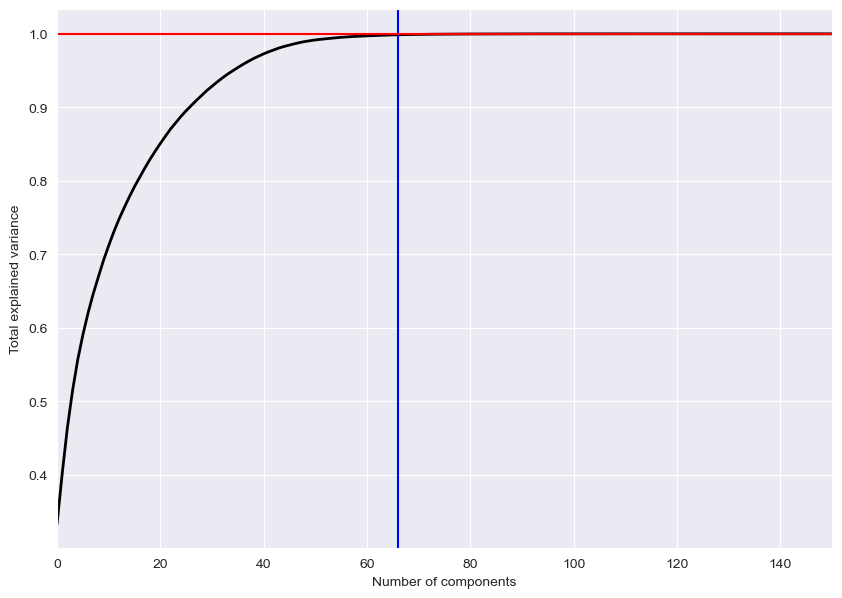

In [93]:
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(PCA_m.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 150)
plt.axvline(66, c='b')
plt.axhline(0.99999, c='r')
plt.show();

Как видно из графика, можно уменьшить разрядность признаков, примерно до 66, ничего при этом не потеряв

In [109]:
PCA_m = PCA(n_components=66)

In [112]:
cat_model2 = CatBoostRegressor(n_estimators=1000,
                               max_depth=10,
                               learning_rate=0.01,
                               task_type="GPU",
                               leaf_estimation_iterations=2,
                               leaf_estimation_backtracking='Armijo',
                               grow_policy='SymmetricTree'
                               )
model2 = Pipeline(
    [
        ('fillna', replacer_for_pipline),
        ('imputer', imp),
        ('OE', cat_encoding),
        ('scaler', MinMaxScaler()),
        ('pca', PCA_m),
        ('model', cat_model2)
    ]
)

In [ ]:
cv = cross_val_score(model2, train_for_PCA, log_y, scoring='neg_mean_squared_log_error', error_score='raise', cv=3)

In [116]:
print(f'RMSLE для PCA c 66 признаками: {np.sqrt(cv.mean() * -1)}')

RMSLE для PCA c 66 признаками: 0.03565467797195048


In [ ]:
model2.fit(train_for_PCA, log_y)

In [115]:
predict_PCA = model2.predict(test_set)
results = pd.concat([test_set.id, pd.Series(np.exp(predict_PCA))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_PCA66.csv', index=False)

# Создадим сет для предсказаний на Dash

In [ ]:
to_predict = pd.DataFrame(df_transformer(train_set))

In [ ]:
to_predict.columns = df_transformer(train_set).columns

In [ ]:
to_predict = to_predict.groupby(['product_type', 'sub_area'], as_index=False).agg({
    'full_sq': 'median',
    'life_sq': 'median',
    'floor': 'median',
    'max_floor': 'median',
    'material': 'median',
    'build_year': 'median',
    'num_room': 'median',
    'kitch_sq': 'median',
    'state': 'median',
    'product_type': pd.Series.mode,
    'sub_area': pd.Series.mode,
    'area_m': 'median',
    'raion_popul': 'median',
    'green_zone_part': 'median',
    'indust_part': 'median',
    'children_preschool': 'median',
    'preschool_quota': 'median',
    'preschool_education_centers_raion': 'median',
    'children_school': 'median',
    'school_quota': 'median',
    'school_education_centers_raion': 'median',
    'school_education_centers_top_20_raion': 'median',
    'hospital_beds_raion': 'median',
    'healthcare_centers_raion': 'median',
    'university_top_20_raion': 'median',
    'sport_objects_raion': 'median',
    'additional_education_raion': 'median',
    'culture_objects_top_25': pd.Series.mode,
    'culture_objects_top_25_raion': 'median',
    'shopping_centers_raion': 'median',
    'office_raion': 'median',
    'thermal_power_plant_raion': pd.Series.mode,
    'incineration_raion': pd.Series.mode,
    'oil_chemistry_raion': pd.Series.mode,
    'radiation_raion': pd.Series.mode,
    'railroad_terminal_raion': pd.Series.mode,
    'big_market_raion': pd.Series.mode,
    'nuclear_reactor_raion': pd.Series.mode,
    'detention_facility_raion': pd.Series.mode,
    'full_all': 'median',
    'male_f': 'median',
    'female_f': 'median',
    'young_all': 'median',
    'young_male': 'median',
    'young_female': 'median',
    'work_all': 'median',
    'work_male': 'median',
    'work_female': 'median',
    'ekder_all': 'median',
    'ekder_male': 'median',
    'ekder_female': 'median',
    '0_6_all': 'median',
    '0_6_male': 'median',
    '0_6_female': 'median',
    '7_14_all': 'median',
    '7_14_male': 'median',
    '7_14_female': 'median',
    '0_17_all': 'median',
    '0_17_male': 'median',
    '0_17_female': 'median',
    '16_29_all': 'median',
    '16_29_male': 'median',
    '16_29_female': 'median',
    '0_13_all': 'median',
    '0_13_male': 'median',
    '0_13_female': 'median',
    'raion_build_count_with_material_info': 'median',
    'build_count_block': 'median',
    'build_count_wood': 'median',
    'build_count_frame': 'median',
    'build_count_brick': 'median',
    'build_count_monolith': 'median',
    'build_count_panel': 'median',
    'build_count_foam': 'median',
    'build_count_slag': 'median',
    'build_count_mix': 'median',
    'raion_build_count_with_builddate_info': 'median',
    'build_count_before_1920': 'median',
    'build_count_1921-1945': 'median',
    'build_count_1946-1970': 'median',
    'build_count_1971-1995': 'median',
    'build_count_after_1995': 'median',
    'ID_metro': 'median',
    'metro_min_avto': 'median',
    'metro_km_avto': 'median',
    'metro_min_walk': 'median',
    'metro_km_walk': 'median',
    'kindergarten_km': 'median',
    'school_km': 'median',
    'park_km': 'median',
    'green_zone_km': 'median',
    'industrial_km': 'median',
    'water_treatment_km': 'median',
    'cemetery_km': 'median',
    'incineration_km': 'median',
    'railroad_station_walk_km': 'median',
    'railroad_station_walk_min': 'median',
    'ID_railroad_station_walk': 'median',
    'railroad_station_avto_km': 'median',
    'railroad_station_avto_min': 'median',
    'ID_railroad_station_avto': 'median',
    'public_transport_station_km': 'median',
    'public_transport_station_min_walk': 'median',
    'water_km': 'median',
    'water_1line': pd.Series.mode,
    'mkad_km': 'median',
    'ttk_km': 'median',
    'sadovoe_km': 'median',
    'bulvar_ring_km': 'median',
    'kremlin_km': 'median',
    'big_road1_km': 'median',
    'ID_big_road1': 'median',
    'big_road1_1line': pd.Series.mode,
    'big_road2_km': 'median',
    'ID_big_road2': 'median',
    'railroad_km': 'median',
    'railroad_1line': pd.Series.mode,
    'zd_vokzaly_avto_km': 'median',
    'ID_railroad_terminal': 'median',
    'bus_terminal_avto_km': 'median',
    'ID_bus_terminal': 'median',
    'oil_chemistry_km': 'median',
    'nuclear_reactor_km': 'median',
    'radiation_km': 'median',
    'power_transmission_line_km': 'median',
    'thermal_power_plant_km': 'median',
    'ts_km': 'median',
    'big_market_km': 'median',
    'market_shop_km': 'median',
    'fitness_km': 'median',
    'swim_pool_km': 'median',
    'ice_rink_km': 'median',
    'stadium_km': 'median',
    'basketball_km': 'median',
    'hospice_morgue_km': 'median',
    'detention_facility_km': 'median',
    'public_healthcare_km': 'median',
    'university_km': 'median',
    'workplaces_km': 'median',
    'shopping_centers_km': 'median',
    'office_km': 'median',
    'additional_education_km': 'median',
    'preschool_km': 'median',
    'big_church_km': 'median',
    'church_synagogue_km': 'median',
    'mosque_km': 'median',
    'theater_km': 'median',
    'museum_km': 'median',
    'exhibition_km': 'median',
    'catering_km': 'median',
    'ecology': pd.Series.mode,
    'green_part_500': 'median',
    'prom_part_500': 'median',
    'office_count_500': 'median',
    'office_sqm_500': 'median',
    'trc_count_500': 'median',
    'trc_sqm_500': 'median',
    'cafe_count_500': 'median',
    'cafe_sum_500_min_price_avg': 'median',
    'cafe_sum_500_max_price_avg': 'median',
    'cafe_avg_price_500': 'median',
    'cafe_count_500_na_price': 'median',
    'cafe_count_500_price_500': 'median',
    'cafe_count_500_price_1000': 'median',
    'cafe_count_500_price_1500': 'median',
    'cafe_count_500_price_2500': 'median',
    'cafe_count_500_price_4000': 'median',
    'cafe_count_500_price_high': 'median',
    'big_church_count_500': 'median',
    'church_count_500': 'median',
    'mosque_count_500': 'median',
    'leisure_count_500': 'median',
    'sport_count_500': 'median',
    'market_count_500': 'median',
    'green_part_1000': 'median',
    'prom_part_1000': 'median',
    'office_count_1000': 'median',
    'office_sqm_1000': 'median',
    'trc_count_1000': 'median',
    'trc_sqm_1000': 'median',
    'cafe_count_1000': 'median',
    'cafe_sum_1000_min_price_avg': 'median',
    'cafe_sum_1000_max_price_avg': 'median',
    'cafe_avg_price_1000': 'median',
    'cafe_count_1000_na_price': 'median',
    'cafe_count_1000_price_500': 'median',
    'cafe_count_1000_price_1000': 'median',
    'cafe_count_1000_price_1500': 'median',
    'cafe_count_1000_price_2500': 'median',
    'cafe_count_1000_price_4000': 'median',
    'cafe_count_1000_price_high': 'median',
    'big_church_count_1000': 'median',
    'church_count_1000': 'median',
    'mosque_count_1000': 'median',
    'leisure_count_1000': 'median',
    'sport_count_1000': 'median',
    'market_count_1000': 'median',
    'green_part_1500': 'median',
    'prom_part_1500': 'median',
    'office_count_1500': 'median',
    'office_sqm_1500': 'median',
    'trc_count_1500': 'median',
    'trc_sqm_1500': 'median',
    'cafe_count_1500': 'median',
    'cafe_sum_1500_min_price_avg': 'median',
    'cafe_sum_1500_max_price_avg': 'median',
    'cafe_avg_price_1500': 'median',
    'cafe_count_1500_na_price': 'median',
    'cafe_count_1500_price_500': 'median',
    'cafe_count_1500_price_1000': 'median',
    'cafe_count_1500_price_1500': 'median',
    'cafe_count_1500_price_2500': 'median',
    'cafe_count_1500_price_4000': 'median',
    'cafe_count_1500_price_high': 'median',
    'big_church_count_1500': 'median',
    'church_count_1500': 'median',
    'mosque_count_1500': 'median',
    'leisure_count_1500': 'median',
    'sport_count_1500': 'median',
    'market_count_1500': 'median',
    'green_part_2000': 'median',
    'prom_part_2000': 'median',
    'office_count_2000': 'median',
    'office_sqm_2000': 'median',
    'trc_count_2000': 'median',
    'trc_sqm_2000': 'median',
    'cafe_count_2000': 'median',
    'cafe_sum_2000_min_price_avg': 'median',
    'cafe_sum_2000_max_price_avg': 'median',
    'cafe_avg_price_2000': 'median',
    'cafe_count_2000_na_price': 'median',
    'cafe_count_2000_price_500': 'median',
    'cafe_count_2000_price_1000': 'median',
    'cafe_count_2000_price_1500': 'median',
    'cafe_count_2000_price_2500': 'median',
    'cafe_count_2000_price_4000': 'median',
    'cafe_count_2000_price_high': 'median',
    'big_church_count_2000': 'median',
    'church_count_2000': 'median',
    'mosque_count_2000': 'median',
    'leisure_count_2000': 'median',
    'sport_count_2000': 'median',
    'market_count_2000': 'median',
    'green_part_3000': 'median',
    'prom_part_3000': 'median',
    'office_count_3000': 'median',
    'office_sqm_3000': 'median',
    'trc_count_3000': 'median',
    'trc_sqm_3000': 'median',
    'cafe_count_3000': 'median',
    'cafe_sum_3000_min_price_avg': 'median',
    'cafe_sum_3000_max_price_avg': 'median',
    'cafe_avg_price_3000': 'median',
    'cafe_count_3000_na_price': 'median',
    'cafe_count_3000_price_500': 'median',
    'cafe_count_3000_price_1000': 'median',
    'cafe_count_3000_price_1500': 'median',
    'cafe_count_3000_price_2500': 'median',
    'cafe_count_3000_price_4000': 'median',
    'cafe_count_3000_price_high': 'median',
    'big_church_count_3000': 'median',
    'church_count_3000': 'median',
    'mosque_count_3000': 'median',
    'leisure_count_3000': 'median',
    'sport_count_3000': 'median',
    'market_count_3000': 'median',
    'green_part_5000': 'median',
    'prom_part_5000': 'median',
    'office_count_5000': 'median',
    'office_sqm_5000': 'median',
    'trc_count_5000': 'median',
    'trc_sqm_5000': 'median',
    'cafe_count_5000': 'median',
    'cafe_sum_5000_min_price_avg': 'median',
    'cafe_sum_5000_max_price_avg': 'median',
    'cafe_avg_price_5000': 'median',
    'cafe_count_5000_na_price': 'median',
    'cafe_count_5000_price_500': 'median',
    'cafe_count_5000_price_1000': 'median',
    'cafe_count_5000_price_1500': 'median',
    'cafe_count_5000_price_2500': 'median',
    'cafe_count_5000_price_4000': 'median',
    'cafe_count_5000_price_high': 'median',
    'big_church_count_5000': 'median',
    'church_count_5000': 'median',
    'mosque_count_5000': 'median',
    'leisure_count_5000': 'median',
    'sport_count_5000': 'median',
    'market_count_5000': 'median',
    'oil_urals': 'median',
    'gdp_quart': 'median',
    'gdp_quart_growth': 'median',
    'cpi': 'median',
    'ppi': 'median',
    'gdp_deflator': 'median',
    'balance_trade': 'median',
    'balance_trade_growth': 'median',
    'usdrub': 'median',
    'eurrub': 'median',
    'brent': 'median',
    'net_capital_export': 'median',
    'gdp_annual': 'median',
    'gdp_annual_growth': 'median',
    'average_provision_of_build_contract': 'median',
    'average_provision_of_build_contract_moscow': 'median',
    'rts': 'median',
    'micex': 'median',
    'micex_rgbi_tr': 'median',
    'micex_cbi_tr': 'median',
    'deposits_value': 'median',
    'deposits_growth': 'median',
    'deposits_rate': 'median',
    'mortgage_value': 'median',
    'mortgage_growth': 'median',
    'mortgage_rate': 'median',
    'grp': 'median',
    'grp_growth': 'median',
    'income_per_cap': 'median',
    'real_dispos_income_per_cap_growth': 'median',
    'salary': 'median',
    'salary_growth': 'median',
    'fixed_basket': 'median',
    'retail_trade_turnover': 'median',
    'retail_trade_turnover_per_cap': 'median',
    'retail_trade_turnover_growth': 'median',
    'labor_force': 'median',
    'unemployment': 'median',
    'employment': 'median',
    'invest_fixed_capital_per_cap': 'median',
    'invest_fixed_assets': 'median',
    'profitable_enterpr_share': 'median',
    'unprofitable_enterpr_share': 'median',
    'share_own_revenues': 'median',
    'overdue_wages_per_cap': 'median',
    'fin_res_per_cap': 'median',
    'marriages_per_1000_cap': 'median',
    'divorce_rate': 'median',
    'construction_value': 'median',
    'invest_fixed_assets_phys': 'median',
    'pop_natural_increase': 'median',
    'pop_migration': 'median',
    'pop_total_inc': 'median',
    'childbirth': 'median',
    'mortality': 'median',
    'housing_fund_sqm': 'median',
    'lodging_sqm_per_cap': 'median',
    'water_pipes_share': 'median',
    'baths_share': 'median',
    'sewerage_share': 'median',
    'gas_share': 'median',
    'hot_water_share': 'median',
    'electric_stove_share': 'median',
    'heating_share': 'median',
    'old_house_share': 'median',
    'average_life_exp': 'median',
    'infant_mortarity_per_1000_cap': 'median',
    'perinatal_mort_per_1000_cap': 'median',
    'incidence_population': 'median',
    'rent_price_4+room_bus': 'median',
    'rent_price_3room_bus': 'median',
    'rent_price_2room_bus': 'median',
    'rent_price_1room_bus': 'median',
    'rent_price_3room_eco': 'median',
    'rent_price_2room_eco': 'median',
    'rent_price_1room_eco': 'median',
    'load_of_teachers_preschool_per_teacher': 'median',
    'child_on_acc_pre_school': 'median',
    'load_of_teachers_school_per_teacher': 'median',
    'students_state_oneshift': 'median',
    'modern_education_share': 'median',
    'old_education_build_share': 'median',
    'provision_doctors': 'median',
    'provision_nurse': 'median',
    'load_on_doctors': 'median',
    'power_clinics': 'median',
    'hospital_beds_available_per_cap': 'median',
    'hospital_bed_occupancy_per_year': 'median',
    'provision_retail_space_sqm': 'median',
    'provision_retail_space_modern_sqm': 'median',
    'turnover_catering_per_cap': 'median',
    'theaters_viewers_per_1000_cap': 'median',
    'seats_theather_rfmin_per_100000_cap': 'median',
    'museum_visitis_per_100_cap': 'median',
    'bandwidth_sports': 'median',
    'population_reg_sports_share': 'median',
    'students_reg_sports_share': 'median',
    'apartment_build': 'median',
    'apartment_fund_sqm': 'median',
    'year': 'median',
    'month': 'median',
    'day': 'median',
})
to_predict = to_predict.applymap(lambda x: x[0] if type(x) == 'list' else x)
to_predict = to_predict.applymap(
    lambda x: x[0] if str(type(x)) == "<class 'pandas.core.arrays.categorical.Categorical'>" else x)
to_predict = to_predict.applymap(lambda x: x.iloc[0] if str(type(x)) == "<class 'pandas.core.series.Series'>" else x)
to_predict = to_predict[df_transformer(train_set).columns]
to_predict.dropna(how='all', inplace=True)

In [ ]:
to_predict.to_csv(os.path.join('data', 'set_for_dash.csv'), index=False)

In [ ]:
test_set_imp = pd.DataFrame(imp.fit_transform(test_set))
test_set_imp.columns = test_set.columns

test_j1_i = test_set_imp[['id',
                          'full_sq',
                          'build_year',
                          'product_type',
                          'sub_area']][test_set_imp[['id',
                                                     'full_sq',
                                                     'build_year',
                                                     'product_type',
                                                     'sub_area']].product_type == 'Investment'].copy()
test_j2_i = to_predict.drop(['full_sq',
                             'build_year'], axis=1)[to_predict.drop(['full_sq',
                                                                     'build_year'],
                                                                    axis=1).product_type == 'Investment'].copy()

test_j2_i = test_j2_i.drop('product_type', axis=1)

test_j1_o = test_set_imp[['id',
                          'full_sq',
                          'build_year',
                          'product_type',
                          'sub_area']][test_set_imp[['id',
                                                     'full_sq',
                                                     'build_year',
                                                     'product_type',
                                                     'sub_area']].product_type == 'OwnerOccupier'].copy()
test_j2_o = to_predict.drop(['full_sq',
                             'build_year'], axis=1)[to_predict.drop(['full_sq',
                                                                     'build_year'],
                                                                    axis=1).product_type == 'OwnerOccupier'].copy()

test_j2_o = test_j2_o.drop('product_type', axis=1)

In [ ]:
test_j1_i = test_j1_i.merge(test_j2_i, on='sub_area', how='left')
test_j1_o = test_j1_o.merge(test_j2_o, on='sub_area', how='left')
test_to_pred = pd.concat([test_j1_i, test_j1_o], axis=0).sort_values('id')[df_transformer(train_set).columns]

In [ ]:
def transf_test(df):
    # Определим коэффициент различия жилой и общей площади
    df.reset_index(drop=True, inplace=True)
    life_sq_coef = np.mean(df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].life_sq /
                           df[(df.life_sq != 0) &
                              (df.full_sq != 0) &
                              (df.life_sq < df.full_sq)].full_sq)

    life_sq_to_change = df[(df.life_sq > df.full_sq) &
                           (df.full_sq > 20)].index.tolist()

    for i in life_sq_to_change:
        df.iloc[i, 3] = df.iloc[i].full_sq * life_sq_coef

    # Также преобразуем общую площадь, т.к. остались объекты с общей площадью < 20 кв. м и с большой жилой
    full_sq_to_change = df[df.life_sq > df.full_sq].index.tolist()

    for i in full_sq_to_change:
        df.iloc[i, 2] = df.iloc[i].life_sq / life_sq_coef

    indexes = df.life_sq[df.life_sq.isna()].index
    to_fill = df.life_sq[df.life_sq.isna()].copy()
    to_fill = df.full_sq[indexes] * life_sq_coef
    df.life_sq.fillna(to_fill, inplace=True)

    # Вот так выглядят данные после преобразования
    #sns.scatterplot(x='full_sq', y='life_sq', data=df[['full_sq', 'life_sq']])
    #plt.show();

    # год постройки имеет несуществущие значения. Целесообразно преобразовать
    if 'build_year' in df.columns:
        if df.build_year[(df.build_year > 1700) & (df.build_year < 2022)].any():
            mean_year = round(df.build_year[(df.build_year > 1700) &
                                            (df.build_year < 2022)].mean())

            df.build_year = df.build_year.fillna(mean_year)
            df.loc[~((df.build_year > 1700) &
                     (df.build_year < 2022)), 'build_year'] = mean_year

    mean_change = ['floor', 'max_floor', 'material', 'preschool_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'preschool_quota', 'school_quota',
                   'raion_build_count_with_material_info',
                   'build_count_block', 'build_count_wood',
                   'build_count_frame', 'build_count_brick',
                   'build_count_monolith', 'build_count_panel',
                   'build_count_foam', 'build_count_slag',
                   'build_count_mix', 'raion_build_count_with_builddate_info',
                   'build_count_before_1920', 'build_count_1921-1945',
                   'build_count_1946-1970', 'build_count_1971-1995',
                   'build_count_after_1995', 'metro_min_walk',
                   'metro_km_walk', 'ID_railroad_station_walk',
                   'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
                   'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
                   'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
                   'cafe_avg_price_1500', 'cafe_sum_2000_min_price_avg',
                   'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'prom_part_5000']

    median_change = ['num_room', 'kitch_sq', 'state', 'school_quota',
                     'hospital_beds_raion', 'metro_min_walk', 'metro_km_walk',
                     'railroad_station_walk_km', 'railroad_station_walk_min',
                     'cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg',
                     'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
                     'cafe_avg_price_3000', 'cafe_sum_5000_min_price_avg',
                     'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
                     ]

    for i in mean_change:
        if i in df.columns:
            df[i].fillna(df[i].mean(), inplace=True)
    for i in median_change:
        if i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)


    for i in df.columns:
        col_type = df[i].dtype
        if col_type == 'object':
            df[i] = df[i].astype('category')

    return df

In [ ]:
test_to_pred = transf_test(test_to_pred)
test_to_pred.select_dtypes(include='object')
test_to_pred.build_year = test_to_pred.full_sq.astype(float)

In [ ]:
for i in test_to_pred.columns:
    if test_to_pred[i].dtype != 'category':
        test_to_pred[i] = test_to_pred[i].fillna(test_to_pred[i].median())

In [ ]:
cat_model = CatBoostRegressor()

cat_model.load_model('catboost_model.cbm')

In [ ]:
pred_log = cat_model.predict(imp.fit_transform(test_to_pred))
results = pd.concat([test_set.id, pd.Series(np.exp(pred_log))], axis=1)
results.columns = ['id', 'price_doc']
results.to_csv('results_dash.csv', index=False)